In [1]:
import pandas as pd
import os
import glob

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
import rasterio

In [3]:
sns.set_style('whitegrid')

In [4]:
expname = 'finetune_QCD_segmbox_alpha'

In [5]:
expdir = f'../logs/evaluations/runs/{expname}/'
np.sort(os.listdir(expdir))

array(['2024-06-12_23-06-36', '2024-06-12_23-14-25',
       '2024-06-12_23-19-50', '2024-06-12_23-25-11',
       '2024-06-12_23-30-21', '2024-06-12_23-35-32',
       '2024-06-12_23-40-42', '2024-06-12_23-45-57',
       '2024-06-12_23-51-07', '2024-06-12_23-56-17',
       '2024-06-13_00-01-27', '2024-06-13_00-06-34',
       '2024-06-13_00-11-48', '2024-06-13_00-17-02',
       '2024-06-13_00-22-14', '2024-06-13_00-27-30',
       '2024-06-13_00-32-44', '2024-06-13_00-37-56',
       '2024-06-13_00-43-12', '2024-06-13_00-48-29',
       '2024-06-13_00-53-43', '2024-06-13_00-58-56',
       '2024-06-13_01-04-12', '2024-06-13_01-09-25',
       '2024-06-13_01-14-38'], dtype='<U19')

In [6]:
all_logdirs = [os.path.join(expdir, dd) for dd in np.sort(os.listdir(expdir))]

In [7]:
logdirs = []
folds = []
img_files = []

fold_key = None

for i, logdir in enumerate(all_logdirs):
    if os.path.exists(os.path.join(logdir, f'test_predictions.csv')):
        logdirs.append(logdir)
        folds.append(i)
        print(i)
            
        with open(os.path.join(logdir, 'config_tree.log')) as f:
            img_file = 'None'
            config_tree = f.readlines()
            for l in config_tree:
                if 'jpg' in l:
                    img_file = l.strip().split(' ')[-1]
            img_files.append(img_file)
    else:
        print(logdir)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [8]:
config_tree

['CONFIG\n',
 '├── datamodule\n',
 '│   └── _target_: ai4eo_mapyourcity.datamodules.mapyourcity_datamodule.MapYourCi\n',
 '│       batch_size: 8                                                           \n',
 '│       num_workers: 8                                                          \n',
 '│       pin_memory: false                                                       \n',
 '│       dataset_options:                                                        \n',
 '│         transform: default                                                    \n',
 '│         data_dir: /work/ka1176/caroline/gitlab/AI4EO-MapYourCity/scripts/../da\n',
 '│         fold: 0                                                               \n',
 '│         fold_dir: /work/ka1176/caroline/gitlab/AI4EO-MapYourCity/scripts/../da\n',
 '│         fold_key: random_stratified_labels_cities_noHUN                       \n',
 '│         model_id:                                                             \n',
 '│      

In [9]:
for l in config_tree:
    if 'fold_key' in l:
        fold_key = l.strip().split(' ')[-1]
    if 'jpg' in l:
        img_file = l.strip().split(' ')[-1]
print(fold_key)
print(img_file)

random_stratified_labels_cities_noHUN
street_segmbox.jpg


In [10]:
test_set = pd.read_csv('../data/AI4EO-MapYourCity/v1/building-age-dataset/test/test-set.csv')
test_set['country_id'].value_counts()

country_id
QCD    2089
FMW    1428
PNN     934
HUN      78
Name: count, dtype: int64

In [11]:
countries_fold = {'0':'QCD', '1':'QCD', '2':'QCD', '3':'QCD', '4':'QCD',
                  '5':'PNN', '6':'PNN', '7':'PNN', '8':'PNN', '9':'PNN',
                  '10':'HUN', '11':'HUN', '12':'HUN', '13':'HUN', '14':'HUN',
                  '15':'FMW', '16':'FMW', '17':'FMW', '18':'FMW', '19':'FMW'
                 }

In [12]:
all_test_df = []
all_valid_df = []

all_pids = []

for fold, img_file, logdir in zip(folds, img_files, logdirs):
    
    rnd = {'predicted_labels':'predicted_label'}
    
    tt = pd.read_csv(os.path.join(logdir, f'test_predictions.csv')).rename(columns=rnd)
    vv = pd.read_csv(os.path.join(logdir, f'dev_predictions.csv')).rename(columns=rnd) 
    dd = pd.read_csv(f'../data/AI4EO-MapYourCity/splits/dev-set.csv') 
    
    # restrict to single country if trained like thid
    if fold_key == 'use_only_one_country_5-fold':
        print('Use only test set from country', countries_fold[str(fold)])
        country_pids = test_set[test_set['country_id'] == countries_fold[str(fold)]]['pid'].values
        print(len(country_pids), ' samples')
        ix = np.zeros(len(tt['pid']))
        for i, pid in enumerate(tt['pid']):
            if pid in country_pids:
                ix[i] = 1.
                
        tt = tt[ix.astype(bool)]
    
    tt['fold'] = fold
    vv['fold'] = fold
    
    all_pids.append(tt['pid'].sort_values().values)
    
    print(len(tt['pid']), 'samples attached to test set')
    all_test_df.append(tt)
    all_valid_df.append(pd.merge(vv, dd, on='pid'))

4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set
4529 samples attached to test set


In [13]:
test_df = pd.concat(all_test_df)
test_df['predicted_label'] = test_df['predicted_label'].astype(int)
test_df.pivot_table(index=['pid', 'fold'])

predicted_label
pid        fold                 
22mhjewvtj 0                 5.0
           1                 5.0
           2                 5.0
           3                 4.0
           4                 5.0
...                          ...
zzvxsygznl 20                0.0
           21                0.0
           22                0.0
           23                0.0
           24                0.0

[113225 rows x 1 columns]

In [14]:
test_df.assign(experiment=expname).to_csv(f'../submissions/all_folds/{expname}.csv', index=False)

In [15]:
ref_df = pd.concat([test_set, dd])

In [16]:
def get_best_class(sdf):
    '''
    Return the majority vote
    If tied, choose class closest to the mean
    
    '''
    
    spids = []
    slbls = []
    
    unique_classes = {}
    modes = {}
    
    class_prob = {'QCD': [5, 3, 4, 2, 0, 1, 6],
         'PNN': [0, 4, 1, 5, 2, 6, 3],
         'HUN': [3, 4, 5, 6, 0, 2, 1],
         'FMW': [0, 3, 4, 5, 2, 6, 1],}
    
    for fold in range(len(test_df.fold.unique())):
        unique_classes[str(fold+1)] = []
        modes[str(fold+1)] = []
    
    # mode did not work with groupby
    for pid in sdf['pid'].unique():
        dd = sdf.loc[sdf['pid'] == pid]
        mode = dd['predicted_label'].mode()
        mean = dd['predicted_label'].mean()
        
        cid = ref_df.query('pid == @pid')['country_id'].values[0]      
        
        unique_classes[str(len(dd['predicted_label'].unique()))].append(pid)
        modes[str(len(mode))].append(pid)
                        
        if len(mode) > 1:
            if False:
                mode = mode.iloc[np.argmin(np.abs(mode-mean))]
            else:
                classes = class_prob[cid]
                for cl in classes:
                    if cl in mode.values:
                        mode = cl
                        break
        else:
            mode = mode.values[0]
            
        spids.append(pid)
        slbls.append(mode)
                
    return pd.DataFrame(dict(pid=spids, predicted_label=slbls)).sort_values('pid'), modes, unique_classes

Restrict folds here: 0, 1, 2, 3, 4 - with all modalities; 5, 6, 7, 8, 9 - streetview dropped

In [64]:
sub_folds = list(range(25))#[0, 1, 2, 3, 4]
dev_folds = [5, 6, 7, 8, 9]

In [65]:
submission_df, submission_modes, submission_classes = get_best_class(test_df.query('fold in @sub_folds'))

In [66]:
submission_df.to_csv(f'../submissions/{expname}.csv', index=False)
submission_df.head(4)

,pid,predicted_label
3997,22mhjewvtj,5
2557,22pujdqtiu,5
1770,23ykackznc,0
3119,2435ikdnmf,1


In [67]:
# how many different modes were predicted by the folds
# 1 - the majority of models agreed on one class
# 2 - tie
# 5 - every fold predicted a different class
for mode in submission_modes:
    print(mode, len(submission_modes[mode]))

1 4417
2 104
3 7
4 1
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0


In [68]:
# how many different classes were predicted by the folds
for mode in submission_classes:
    print(mode, len(submission_classes[mode]))

1 791
2 1271
3 728
4 916
5 617
6 173
7 33
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0


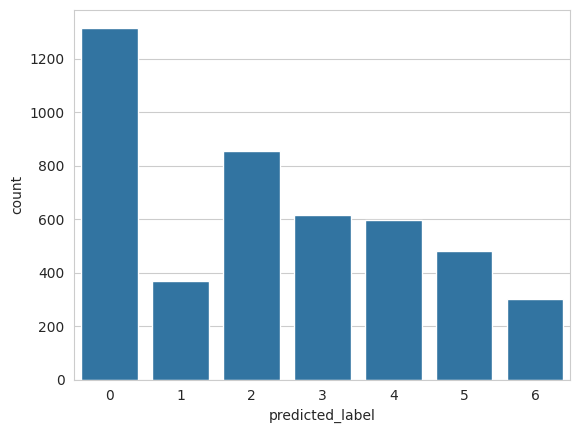

In [69]:
sns.barplot(submission_df['predicted_label'].value_counts().to_frame().reset_index(),
            x='predicted_label', y='count'
           );

In [70]:
reference_submissions = ['merged_topstreet_swin_04-19_A.csv',
                         'multimodal_swin_05-03_C.csv',
                         'multimodal_swin_05-23_B.csv',
                         'topview_streetview_05-27_A.csv',
                         'best_dev_combination_2024-06-01.csv',
                         f'{expname}.csv',
                        ]

In [71]:
tmp = [dd.assign(predicted_label=dd.label)['predicted_label'].value_counts().to_frame().assign(source='dev')]
tmp[0]['count'] *= len(test_set)/len(dd)
all_submissions = pd.concat(tmp + [pd.read_csv(os.path.join('../submissions/', f))['predicted_label'].value_counts().to_frame().assign(source=f) \
                             for f in reference_submissions]).reset_index()

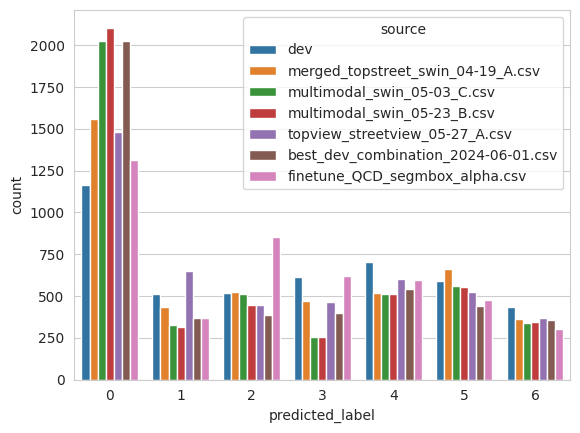

In [72]:
sns.barplot(all_submissions, x='predicted_label', y='count', hue='source');

In [73]:
valid_df = pd.concat(all_valid_df)
valid_df.tail()

,pid,predicted_label,fold,label,country_id,city_id
1492,zyyfnbg8wk,4,24,1,PNN,CESU9
1493,xkumjeu9fb,0,24,0,PNN,CESU9
1494,fxvp42n2mz,4,24,6,PNN,CESU9
1495,3ta88rkntv,4,24,6,PNN,CESU9
1496,vhddbv5wgv,3,24,1,PNN,CESU9


In [74]:
valid_df_M = valid_df.query('fold in @sub_folds') # includes all modalities
valid_df_X = valid_df.query('fold == @dev_folds') # excludes streetview

In [75]:
dev_df_M,_,_ = get_best_class(valid_df_M)
dev_df_X,_,_ = get_best_class(valid_df_X)
dev_df_TV,_,_ = get_best_class(valid_df.query('fold in [10, 11, 12, 13, 14]'))
dev_df_SR,_,_ = get_best_class(valid_df.query('fold in [15, 16, 17, 18, 19]'))
dev_df_S2,_,_ = get_best_class(valid_df.query('fold in [20, 21, 22, 23, 24]'))

In [76]:
dev_df_M = pd.merge(dev_df_M, valid_df_M.drop_duplicates('pid').drop(columns='predicted_label'), 
                    on="pid", how="left")
dev_df_X = pd.merge(dev_df_X, valid_df_X.drop_duplicates('pid').drop(columns='predicted_label'), 
                    on="pid", how="left")
dev_df_TV = pd.merge(dev_df_TV, valid_df_X.drop_duplicates('pid').drop(columns='predicted_label'), 
                    on="pid", how="left")
dev_df_SR = pd.merge(dev_df_SR, valid_df_X.drop_duplicates('pid').drop(columns='predicted_label'), 
                    on="pid", how="left")
dev_df_S2 = pd.merge(dev_df_S2, valid_df_X.drop_duplicates('pid').drop(columns='predicted_label'), 
                    on="pid", how="left")

## Accuracy

In [77]:
Cn_M = confusion_matrix(dev_df_M['label'], dev_df_M['predicted_label'], normalize='true')
C_M = confusion_matrix(dev_df_M['label'], dev_df_M['predicted_label'])
Cn_X = confusion_matrix(dev_df_X['label'], dev_df_X['predicted_label'], normalize='true')
C_X = confusion_matrix(dev_df_X['label'], dev_df_X['predicted_label'])
Cn_TV = confusion_matrix(dev_df_TV['label'], dev_df_TV['predicted_label'], normalize='true')
Cn_SR = confusion_matrix(dev_df_SR['label'], dev_df_SR['predicted_label'], normalize='true')
Cn_S2 = confusion_matrix(dev_df_S2['label'], dev_df_S2['predicted_label'], normalize='true')


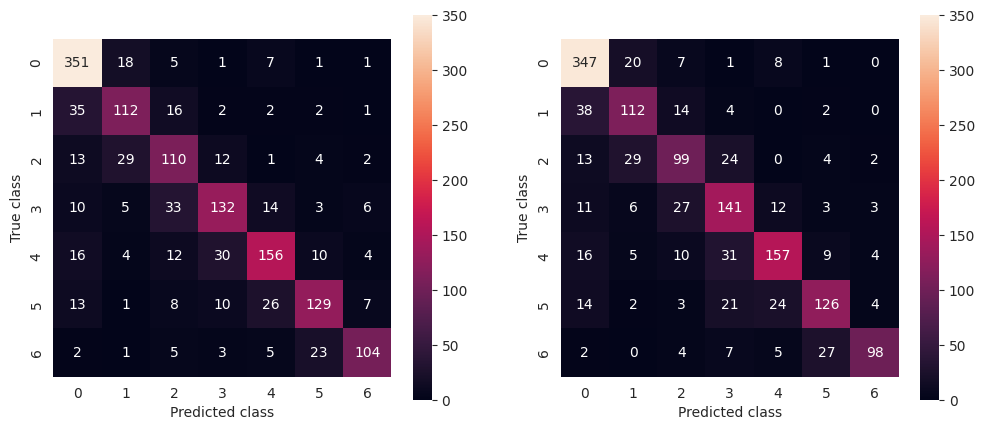

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(C_M, annot=True, fmt='.0f', square=True, vmin=0, vmax=350, ax=ax[0]);
sns.heatmap(C_X, annot=True, fmt='.0f', square=True, vmin=0, vmax=350, ax=ax[1]);
[axx.set_ylabel('True class') for axx in ax]
[axx.set_xlabel('Predicted class') for axx in ax];

In [79]:
acc = accuracy_score(dev_df_M['label'].values, dev_df_M['predicted_label'].values)
print(f'--- All Modalities')
print(f'Accuracy score: {acc:.4f}')
print(f'MAP:            {np.diag(Cn_M).mean():.4f}')

acc = accuracy_score(dev_df_X['label'].values, dev_df_X['predicted_label'].values)
print(f'--- Only Topview Modalities')
print(f'Accuracy score: {acc:.4f}')
print(f'MAP:            {np.diag(Cn_X).mean():.4f}')

print(f'--- Only Orthophoto')
print(f'MAP:            {np.diag(Cn_TV).mean():.4f}')

print(f'--- Only Streetview')
print(f'MAP:            {np.diag(Cn_SR).mean():.4f}')

print(f'--- Only Sentinel-2')
print(f'MAP:            {np.diag(Cn_S2).mean():.4f}')

--- All Modalities
Accuracy score: 0.7308
MAP:            0.7044
--- Only Topview Modalities
Accuracy score: 0.7214
MAP:            0.6925
--- Only Orthophoto
MAP:            0.7085
--- Only Streetview
MAP:            0.6975
--- Only Sentinel-2
MAP:            0.6851


In [80]:
map_df = pd.DataFrame(dict(modalities=['Orthophoto + Street + Sentinel-2',
                                       'Orthophoto + Sentinel-2',
                                       'Orthophoto',
                                       'Street',
                                       'Sentinel-2'
                                      ],
                           scores=[np.diag(Cn_M).mean(),
                                   np.diag(Cn_X).mean(),
                                   np.diag(Cn_TV).mean(),
                                   np.diag(Cn_SR).mean(),
                                   np.diag(Cn_S2).mean()]))

<Axes: xlabel='scores', ylabel='modalities'>

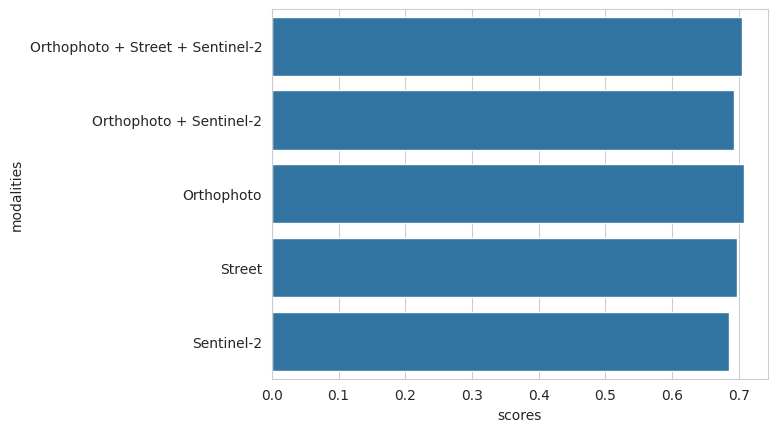

In [81]:
sns.barplot(data=map_df, x='scores', y='modalities')

In [82]:
country_ids = dev_df_M['country_id'].unique()

plot_dfs = []

for country in country_ids:
    country_df = dev_df_M.loc[dev_df_M['country_id'] == country]
    cacc = accuracy_score(country_df['label'].values, country_df['predicted_label'].values)
    
    cmat = confusion_matrix(country_df['label'], country_df['predicted_label'], normalize='true').diagonal()
    
    plot_dfs.append(pd.DataFrame(dict(country=country, classes=list(range(7)), cmat=cmat)))
    
    
    print(f'Country ID: {country}, MCA = {cmat.mean():.4f}, count = {len(country_df)}')

    for fold in sub_folds:
        fold_country_df = valid_df.query('fold == @fold and country_id == @country')
        cmat = confusion_matrix(fold_country_df['label'], fold_country_df['predicted_label'], normalize='true').diagonal().mean()
        sdf = pd.read_csv(f'../data/AI4EO-MapYourCity/splits/{fold_key}/split_train_{fold}.csv').query('country_id == @country')
        print(f'  Fold {fold:2d}: MCA = {cmat:.4f} ({len(sdf)})')

Country ID: QCD, MCA = 0.7396, count = 691
  Fold  0: MCA = 0.7033 (7677)
  Fold  1: MCA = 0.7092 (5750)
  Fold  2: MCA = 0.7107 (7677)
  Fold  3: MCA = 0.7178 (5752)
  Fold  4: MCA = 0.7137 (3852)


FileNotFoundError: [Errno 2] No such file or directory: '../data/AI4EO-MapYourCity/splits/random_stratified_labels_cities_noHUN/split_train_5.csv'

In [ ]:
country_ids = dev_df_X['country_id'].unique()

plot_dfs = []

for country in country_ids:
    country_df = dev_df_X.loc[dev_df_X['country_id'] == country]
    cacc = accuracy_score(country_df['label'].values, country_df['predicted_label'].values)
    
    cmat = confusion_matrix(country_df['label'], country_df['predicted_label'], normalize='true').diagonal()
    
    plot_dfs.append(pd.DataFrame(dict(country=country, classes=list(range(7)), cmat=cmat)))
    
    
    print(f'Country ID: {country}, MCA = {cacc:.4f}, count = {len(country_df)}')

In [ ]:
ff = []
mm = []

folds = valid_df_M['fold'].unique()
for fold in folds:
    country_df = valid_df_M.loc[valid_df_M['fold'] == fold]
    cacc = accuracy_score(country_df['label'].values, country_df['predicted_label'].values)
    cmat = confusion_matrix(country_df['label'], country_df['predicted_label'], normalize='true').diagonal()
    
    print(f'Fold: {fold}, MCA = {cmat.mean():.4f}, count = {len(country_df)}')
    
    ff.append(fold)
    mm.append(cmat.mean())

In [ ]:
tmp = pd.DataFrame(dict(fold=ff, cm=mm))
tmp = tmp.sort_values('cm', ascending=False)

In [ ]:
for i in range(len(tmp)):
    fs = tmp['fold'].values[:i]
    tmp2, _, _ = get_best_class(valid_df.query('fold in @fs'))
    tmp2 = pd.merge(tmp2, valid_df_M.drop_duplicates('pid').drop(columns='predicted_label'), 
                    on="pid", how="left")
    cmat = confusion_matrix(tmp2['label'], tmp2['predicted_label'], normalize='true').diagonal()
    print(i, cmat.mean())

In [ ]:
folds = valid_df_X['fold'].unique()
for fold in folds:
    country_df = valid_df_X.loc[valid_df_X['fold'] == fold]
    cacc = accuracy_score(country_df['label'].values, country_df['predicted_label'].values)
    
    print(f'Fold: {fold}, MCA = {cacc:.4f}, count = {len(country_df)}')

## Inspect mis-classified samples

In [41]:
def inspect_misclassified(tclass, pclass, country_id=None):
    '''
    Pick a random misclassified sample and display
    '''
    
    input_path = "../data/AI4EO-MapYourCity/v1/building-age-dataset/"
    train_path = input_path + "train/data/"
    
    # Choose a building by pid:
    if country_id is None:
        mismatched_df = dev_df_M.query('label==@tclass and predicted_label==@pclass')
    else:
        mismatched_df = dev_df_M.query('label==@tclass and predicted_label==@pclass and country_id==@country_id')
    print(f'{len(mismatched_df)} samples were classified as {pclass} but are {tclass}')

    pid = mismatched_df['pid'].iloc[np.random.randint(len(mismatched_df))]

    print(dev_df_M.loc[dev_df_M['pid'] == pid])
    print('*'*5)
    print(valid_df.loc[valid_df['pid'] == pid])
    street = plt.imread(f"{train_path}/{pid}/street.jpg")
    streetb = plt.imread(f"{train_path}/{pid}/street_patch_tiny.jpg")
    orthophoto = plt.imread(f"{train_path}/{pid}/orthophoto.tif")
    s2 = rasterio.open(f"{train_path}/{pid}/s2_l2a.tif").read()
    s2 = np.transpose(s2,[1,2,0])

    # Show the 3 modalities - street view, orthophoto and Seninel-2

    fig, axs = plt.subplots(figsize=(15, 15), nrows=1, ncols = 4)
    axs = axs.flatten()
    axs[0].imshow(street)
    axs[1].imshow(streetb)
    axs[2].imshow(orthophoto)
    axs[3].imshow(s2[...,[3,2,1]]*3e-4)

    axs[0].set_title("Street")
    axs[1].set_title("Street - Tiny")
    axs[2].set_title("Orthophoto")
    axs[3].set_title("Sentinel-2-L2A")

    plt.show()
    

In [42]:
def inspect_sample(pid, split='train'):
    '''
    Display sample at PID
    '''
    
    input_path = "../data/AI4EO-MapYourCity/v1/building-age-dataset/"
    train_path = os.path.join(input_path, split, 'data')

    print(dev_df_M.loc[dev_df_M['pid'] == pid])
    print(test_df.loc[test_df['pid'] == pid])
    print(test_set.loc[test_set['pid'] == pid])
    
    is_street = False
    if os.path.exists(f"{train_path}/{pid}/street.jpg"):
        is_street = True
        street = plt.imread(f"{train_path}/{pid}/street.jpg")
        streetb = plt.imread(f"{train_path}/{pid}/street_patch_tiny.jpg")
    orthophoto = plt.imread(f"{train_path}/{pid}/orthophoto.tif")
    s2 = rasterio.open(f"{train_path}/{pid}/s2_l2a.tif").read()
    s2 = np.transpose(s2,[1,2,0])

    # Show the 3 modalities - street view, orthophoto and Seninel-2

    fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols = 4)
    axs = axs.flatten()
    if is_street:
        axs[0].imshow(street)
        axs[1].imshow(streetb)
    axs[2].imshow(orthophoto)
    axs[3].imshow(s2[...,[3,2,1]]*3e-4)

    axs[0].set_title("Street")
    axs[1].set_title("Street - Tiny")
    axs[2].set_title("Orthophoto")
    axs[3].set_title("Sentinel-2-L2A")

    plt.show()
    

10 samples were classified as 3 but are 5
             pid  predicted_label  fold  label country_id city_id
1058  mzrqfkas7q                3     0      5        FMW   O8WX6
*****
             pid  predicted_label  fold  label country_id city_id
1471  mzrqfkas7q                6     0      5        FMW   O8WX6
1471  mzrqfkas7q                3     1      5        FMW   O8WX6
1471  mzrqfkas7q                5     2      5        FMW   O8WX6
1471  mzrqfkas7q                3     3      5        FMW   O8WX6
1471  mzrqfkas7q                0     4      5        FMW   O8WX6
1471  mzrqfkas7q                5     5      5        FMW   O8WX6
1471  mzrqfkas7q                3     6      5        FMW   O8WX6
1471  mzrqfkas7q                4     7      5        FMW   O8WX6
1471  mzrqfkas7q                5     8      5        FMW   O8WX6
1471  mzrqfkas7q                3     9      5        FMW   O8WX6
1471  mzrqfkas7q                6    10      5        FMW   O8WX6
1471  mzrqfkas7q            

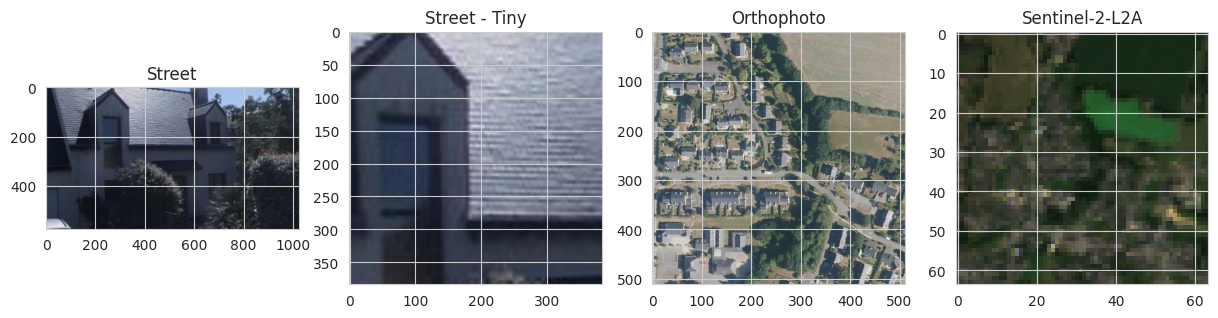

In [43]:
inspect_misclassified(5,3,)

Empty DataFrame
Columns: [pid, predicted_label, fold, label, country_id, city_id]
Index: []
          pid  predicted_label  fold
0  eywttujal8                0     0
0  eywttujal8                0     1
0  eywttujal8                0     2
0  eywttujal8                4     3
0  eywttujal8                0     4
0  eywttujal8                1     5
0  eywttujal8                0     6
0  eywttujal8                0     7
0  eywttujal8                0     8
0  eywttujal8                4     9
0  eywttujal8                0    10
0  eywttujal8                0    11
0  eywttujal8                0    12
0  eywttujal8                5    13
0  eywttujal8                0    14
0  eywttujal8                0    15
0  eywttujal8                0    16
0  eywttujal8                0    17
0  eywttujal8                0    18
0  eywttujal8                4    19
0  eywttujal8                0    20
0  eywttujal8                0    21
0  eywttujal8                0    22
0  eywttujal8       

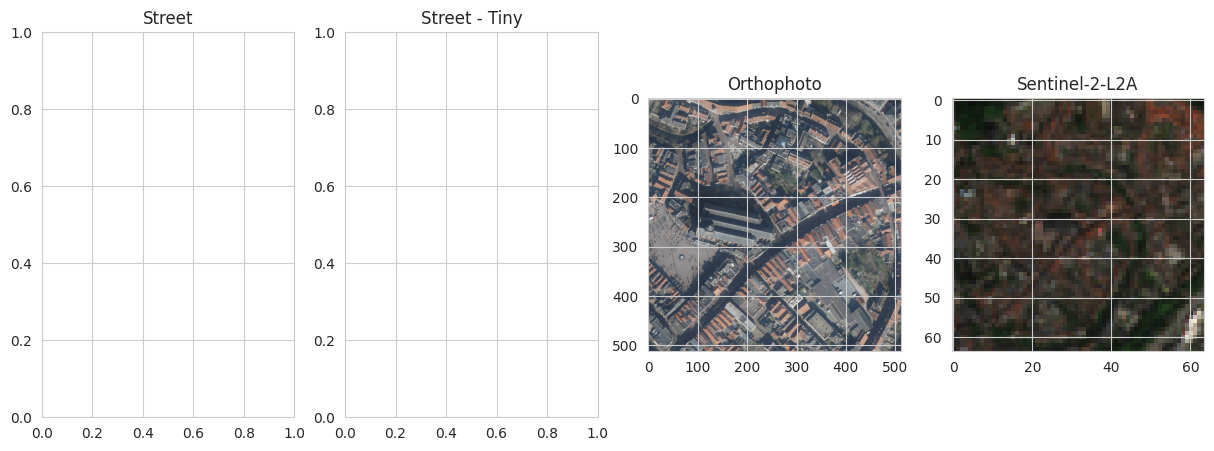

In [44]:
inspect_sample(submission_modes['1'][0], 'test')

## Focus on QCD

- Contains street photos
- 50% of the test set

In [45]:
qcd_pids = []
for pid in submission_modes['2']:
    if test_set.query('pid == @pid')['country_id'].values == 'QCD':
        qcd_pids.append(pid)
        
len(qcd_pids)

75

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Empty DataFrame
Columns: [pid, predicted_label, fold, label, country_id, city_id]
Index: []
             pid  predicted_label  fold
2825  bceppcsts6                3     0
2825  bceppcsts6                2     1
2825  bceppcsts6                1     2
2825  bceppcsts6                3     3
2825  bceppcsts6                1     4
2825  bceppcsts6                2     5
2825  bceppcsts6                3     6
2825  bceppcsts6                1     7
2825  bceppcsts6                2     8
2825  bceppcsts6                3     9
2825  bceppcsts6                3    10
2825  bceppcsts6                3    11
2825  bceppcsts6                1    12
2825  bceppcsts6                1    13
2825  bceppcsts6                2    14
2825  bceppcsts6                2    15
2825  bceppcsts6                2    16
2825  bceppcsts6                1    17
2825  bceppcsts6                2    18
2825  bceppcsts6                1    19
2825  bceppcsts6                2    20
2825  bceppcsts6            

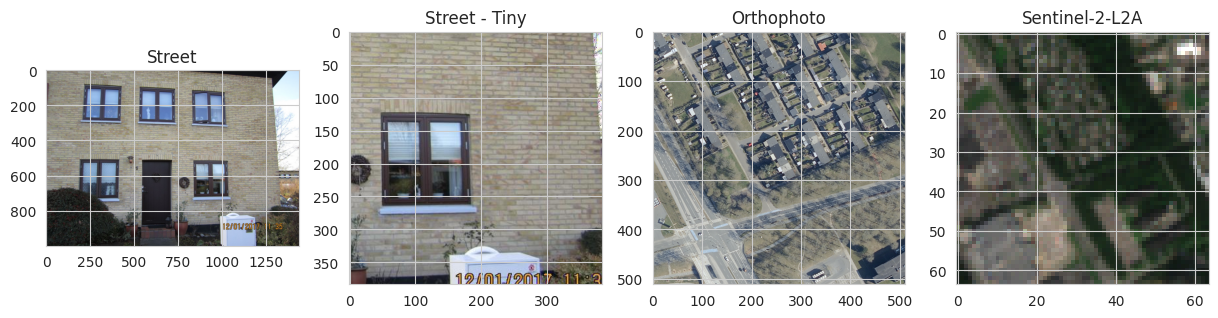

In [46]:
inspect_sample(qcd_pids[20], 'test')

In [47]:
test_set.query('pid == @pid')

,country_id,pid,city_id
4442,QCD,wnxl3bihb2,YPGHW


In [48]:
df1 = test_df.query('pid in @qcd_pids and fold in [0, 1, 2, 3, 4]')
df2 = pd.read_csv('../submissions/all_folds/topview_streetview_05-27_A_HUN.csv').query('pid in @qcd_pids and fold in [0, 1, 2, 3, 4]')
df3 = pd.read_csv('../submissions/all_folds/multimodal_swin_05-23_B.csv').query('pid in @qcd_pids and fold in [0, 1, 2, 3, 4]')
df4 = pd.read_csv('../submissions/all_folds/topview_streetview_05-27_A_HUN_alpha.csv').query('pid in @qcd_pids and fold in [0, 1, 2, 3, 4]')

In [49]:
df2['fold'] = df2['fold'] + 5
df3['fold'] = df3['fold'] + 10
df4['fold'] = df4['fold'] + 10
new_preds, _, _ = get_best_class(pd.concat([df1, df2]))

In [50]:
newdf = pd.merge(submission_df.query('pid in @qcd_pids'), new_preds, on='pid')

<Axes: xlabel='predicted_label_x', ylabel='predicted_label_y'>

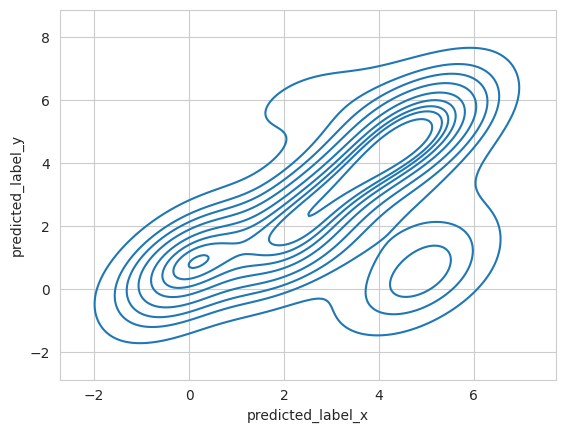

In [51]:
sns.kdeplot(newdf, x='predicted_label_x', y='predicted_label_y')

In [52]:
dd.query('country_id == "QCD"')['label'].value_counts().to_frame().reset_index().sort_values('label')

,label,count
3,0,99
5,1,98
1,2,99
2,3,99
4,4,99
0,5,99
6,6,98


In [53]:
submission_df['predicted_label'].value_counts().to_frame().reset_index().sort_values('predicted_label')

,predicted_label,count
0,0,1817
6,1,274
2,2,543
4,3,444
1,4,623
3,5,519
5,6,309


## Investigate mismatched samples

In [54]:
from sklearn.manifold import TSNE

In [55]:
mismatch = all_valid_df[0]['predicted_label'] != all_valid_df[0]['label']
mis_df = all_valid_df[0][mismatch]
rig_df = all_valid_df[0][~mismatch]

Which countries were misclassified more often?

In [56]:
mis_df['country_id'].value_counts() / (rig_df['country_id'].value_counts() + mis_df['country_id'].value_counts())

country_id
QCD    0.296671
FMW    0.381356
PNN    0.187702
HUN    0.600000
Name: count, dtype: float64

In [57]:
cl = 6

In [58]:
embeddings = {'mismatched':[], 'correct':[], 'all':[]}

for pid in mis_df.query('label == @cl').pid.values:
    emb = np.load(os.path.join(all_logdirs[0], f'{pid}_streetview.npy'))
    embeddings['mismatched'].append(emb)
    
for pid in rig_df.query('label == @cl').pid.values:
    emb = np.load(os.path.join(all_logdirs[0], f'{pid}_streetview.npy'))
    embeddings['correct'].append(emb)

In [59]:
embeddings['all'] = embeddings['mismatched'] + embeddings['correct']

In [60]:
embeddings['all'] = np.asarray(embeddings['all']).squeeze()

In [61]:
tsne = TSNE()

In [62]:
comps = tsne.fit_transform(embeddings['all'])
indicator = np.zeros(len(comps)).astype(bool)
indicator[len(embeddings['mismatched']):] = True

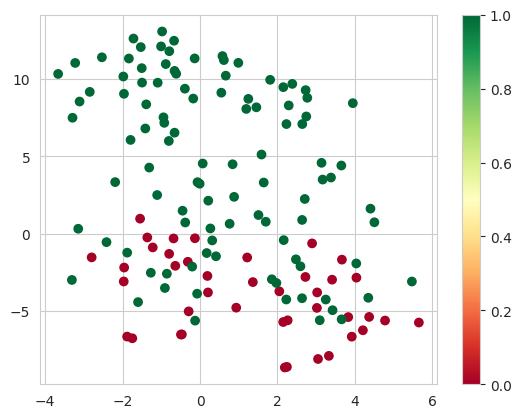

In [63]:
plt.scatter(comps[:,0], comps[:,1], c=indicator, cmap='RdYlGn')
plt.colorbar()

plt.show()